In [1]:
import os, sys, io
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

from numpy import sqrt, exp, pi, square
from tqdm import tqdm
from multiprocessing import Pool

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if sci:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = '$Number\ of\ Entries$')
    else:
        pass

In [2]:
# Read real data
class read_n_concat():   
    __version__ = '0.0.4'

    def __init__(self):
        self.pre_selection = ['True',]
        self.pre_selection = '&'.join(self.pre_selection)
        self._read_flag = True
    
    def process(self, indir = '', outdir = '', number_file_cap = 0, number_cup = 1, force_reload = False):
        self.indir = indir; self.outdir = outdir;
        if not os.path.exists(self.outdir): os.makedirs(self.outdir)
        self.number_file_cap = number_file_cap; self.number_cup = number_cup; self.force_reload = force_reload
        
        # Record all the file in folder, and put a cap on number of files 
        if isinstance(self.number_file_cap, int):
            file_list = [file for file in os.listdir(self.indir) if 'pkl' in file][:self.number_file_cap]
        else:
            file_list = self.number_file_cap
        
        # Process
        if self.number_cup > 1:
            # Use mulithread processing
            with Pool(processes = self.number_cup) as pool:
                self.result = list(tqdm(pool.imap(self._process, file_list, 1), total = len(file_list)))
        
        else:
            # Use a for loop to process
            self.result = []
            with tqdm(total = len(file_list)) as pBar:
                for file in file_list:
                    pBar.update(1)
                    self.result.append(self._process(file))
        
        self.result, self.errors = zip(*self.result)
        
        # Concat result
        if len(self.result) !=0: self.result = pd.concat(self.result)
        
        return self.result
        
    def _process(self, file):
        
        self._process_list = [self._check_existance,
                              self._read_pickle,
                              self._reduce_events,
                              self._reduce_columns,
                              self._write_pickle,
                             ]
        # initiate result in case of process failure
        temp = pd.DataFrame(); error = None
        rolling_kwarg = dict(file = file)
        
        for proc in self._process_list:
            try:
                rolling_kwarg = (proc(**rolling_kwarg))
            except Exception as error:
                return (temp, (proc.__name__,error))
            if rolling_kwarg['finish_flag']:
                return (rolling_kwarg['temp'], error)
            
    def _check_existance(self, file):
        if os.path.isfile(os.path.join(self.outdir, file)) and (not self.force_reload):
            temp = pd.read_pickle(os.path.join(self.outdir, file))
            return dict(temp = temp, file = file, finish_flag = True)
        else:
            return dict(file = file, finish_flag = False)
            
    def _read_pickle(self, file, finish_flag):
        temp = pd.read_pickle(os.path.join(self.indir, file))
        return dict(temp = temp, file = file, finish_flag = False)

    def _reduce_events(self, temp, file, finish_flag):
        clist = ['CutDAQVeto','CutFlash', 'CutS2Tails', 'CutMuonVeto',
                 'CutS1AreaFractionTop', 'CutS1Width', 'CutS1PatternLikelihood', 'CutS1SingleScatter',
                 'CutS2AreaFractionTop', 'CutS2Width', 'CutS2PatternLikelihood', 'CutS2SingleScatter',
                 'CutKryptonMisIdS1', 'CutPosDiff', 'CutS1AreaUpperInjectionFraction', 'CutS1AreaLowerInjectionFraction',
                 'CutPreS2Junk', 'CutInteractionPeaksBiggest',
                 '(z_3d_nn < 0)',
                ]
        
        clist_delay = ['CutDAQVeto','CutFlash', 'CutS2Tails', 'CutMuonVeto',
                       'CutS2AreaFractionTop', 'CutS2Width', 'CutS2SingleScatter',
                       'CutKryptonMisIdS1', '(z_3d_nn < 0)',
                      ]
        
        clist_lxepi = ['CutDAQVeto','CutFlash', 'CutS2Tails', 'CutMuonVeto', 'CutPreS2Junk',
                       'CutS2AreaFractionTop', 'CutS2Width', 'CutS2SingleScatter',
                       'CutKryptonMisIdS1', '(z_3d_nn < 0)',
                      ]

        temp = temp[temp.eval('&'.join(clist_lxepi))]
        return dict(temp = temp, file = file, finish_flag = False)

    def _reduce_columns(self, temp, file, finish_flag):
        clist = ['event_number', 'run_number', 
                 's1', 's2', 'cs1', 'cs2', 'drift_time', 'x_3d_nn', 'y_3d_nn', 'z_3d_nn', 'r_3d_nn',
                 's1_hit_time_mean', 's1_area_fraction_top', 's1_range_50p_area', 's1_pattern_fit', 'largest_other_s1',
                 's2_hit_time_mean', 's2_area_fraction_top', 's2_range_50p_area', 's2_pattern_fit', 'largest_other_s2',
                 
                 's2_rise_time', 's2_range_80p_area', 'sum_s2s_before_main_s1',
                 'largest_other_s2_delay_main_s1', 'largest_other_s2_delay_main_s2', 'largest_other_s2_pattern_fit',
                 
                 'CutInteractionPeaksBiggest', 'CutS1PatternLikelihood', 'CutS1AreaFractionTop', 'CutPosDiff',
                 'CutS1SingleScatter', 'CutS1AreaUpperInjectionFraction', 'CutS1Width', 'CutS1AreaLowerInjectionFraction',
                 'CutS2PatternLikelihood', 'CutPreS2Junk',]
        temp = temp.loc[:, clist]
        return dict(temp = temp, file = file, finish_flag = False)
    
    def _write_pickle(self, temp, file, finish_flag):
        temp.to_pickle(os.path.join(self.outdir, file))
        return dict(temp = temp, file = file, finish_flag = True)
        

In [3]:
rnc = read_n_concat()
IDir = '/project2/lgrandi/zhut/data/cleaned/pax_v6.8.0_Rn220_sciencerun1/'
ODir = '/project2/lgrandi/zhut/data/ce/Sciencerun1_Rn220_EList/'
df_rn = rnc.process(indir = IDir, outdir = ODir, number_file_cap = 50, number_cup = 14, force_reload = False)

100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


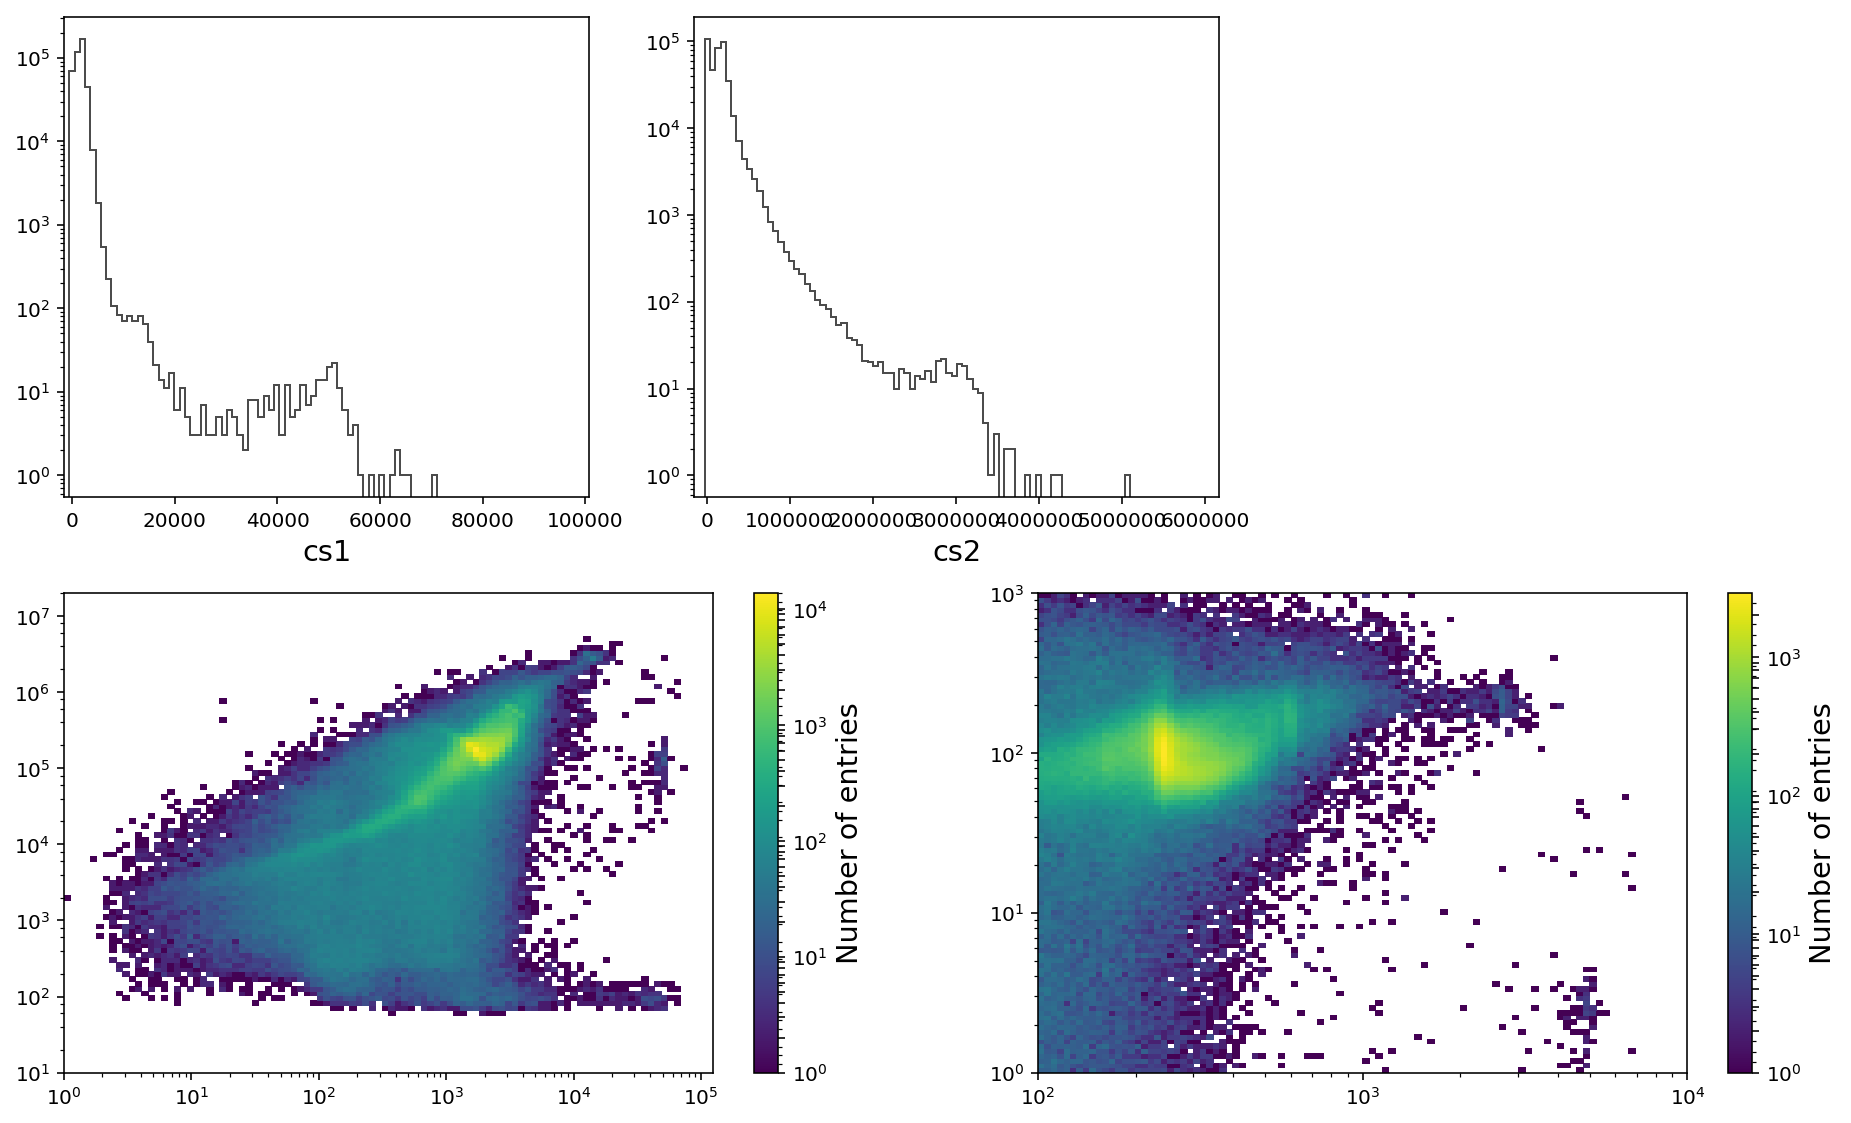

In [4]:
plt.rcParams['figure.figsize'] = (16, 15)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()

args = ['{df}.cs1', '{df}.cs2']
dfs = ['df_rn']
ops = [dict(color = 'k', alpha = 0.7, histtype = 'step', bins = 100),
       dict(color = 'b', alpha = 0.7, histtype = 'step', bins = 100),
      ]

Bx = []
for jx, arg in enumerate(args):
    ax = fig.add_subplot(331+jx)
    for ix, f in enumerate(dfs):
        values = eval(arg.format(df = f))
        
        vs = [np.percentile(values, q) for q in [1, 50, 99.99]]
        xbounds = [vs[1] - (vs[1] - vs[0])*2, vs[1] - (vs[1] - vs[2])*2]
        
        plt.hist(values, range = xbounds, **ops[ix])
        plt_config(xlabel = arg[5:], xbounds = xbounds)
        plt.yscale('log')
        
    Bx.append(xbounds)
    
_Bx = np.array([[1, 1.5e5], [100, 3e6]])
_Bx = np.array([[1, 1.25e5], [10, 2e7]])
_Bx[_Bx < 0] = 1
_Bx = np.log10(_Bx)


ax = fig.add_subplot(323)
mh = Histdd(eval(args[0].format(df = f)), eval(args[1].format(df = f)),
            bins = [np.logspace(_Bx[0,0], _Bx[0,1], 101), np.logspace(_Bx[1,0], _Bx[1,1],101)]
           )
mh.plot(log_scale = True, alpha = 1.0, cmap=plt.get_cmap('viridis'), )
plt.xscale('log'); plt.yscale('log')

ax = fig.add_subplot(324)
args = ['({df}.cs2*(1-{df}.s2_area_fraction_top)/11.38+{df}.cs1/0.142)*0.0137', '{df}.cs2/{df}.cs1']
mh = Histdd(eval(args[0].format(df = f)), eval(args[1].format(df = f)),
            bins = [np.logspace(2, 4, 101), np.logspace(0, 3,101)]
           )
mh.plot(log_scale = True, alpha = 1.0, cmap=plt.get_cmap('viridis'), )
plt.xscale('log'); plt.yscale('log')

plt.show()

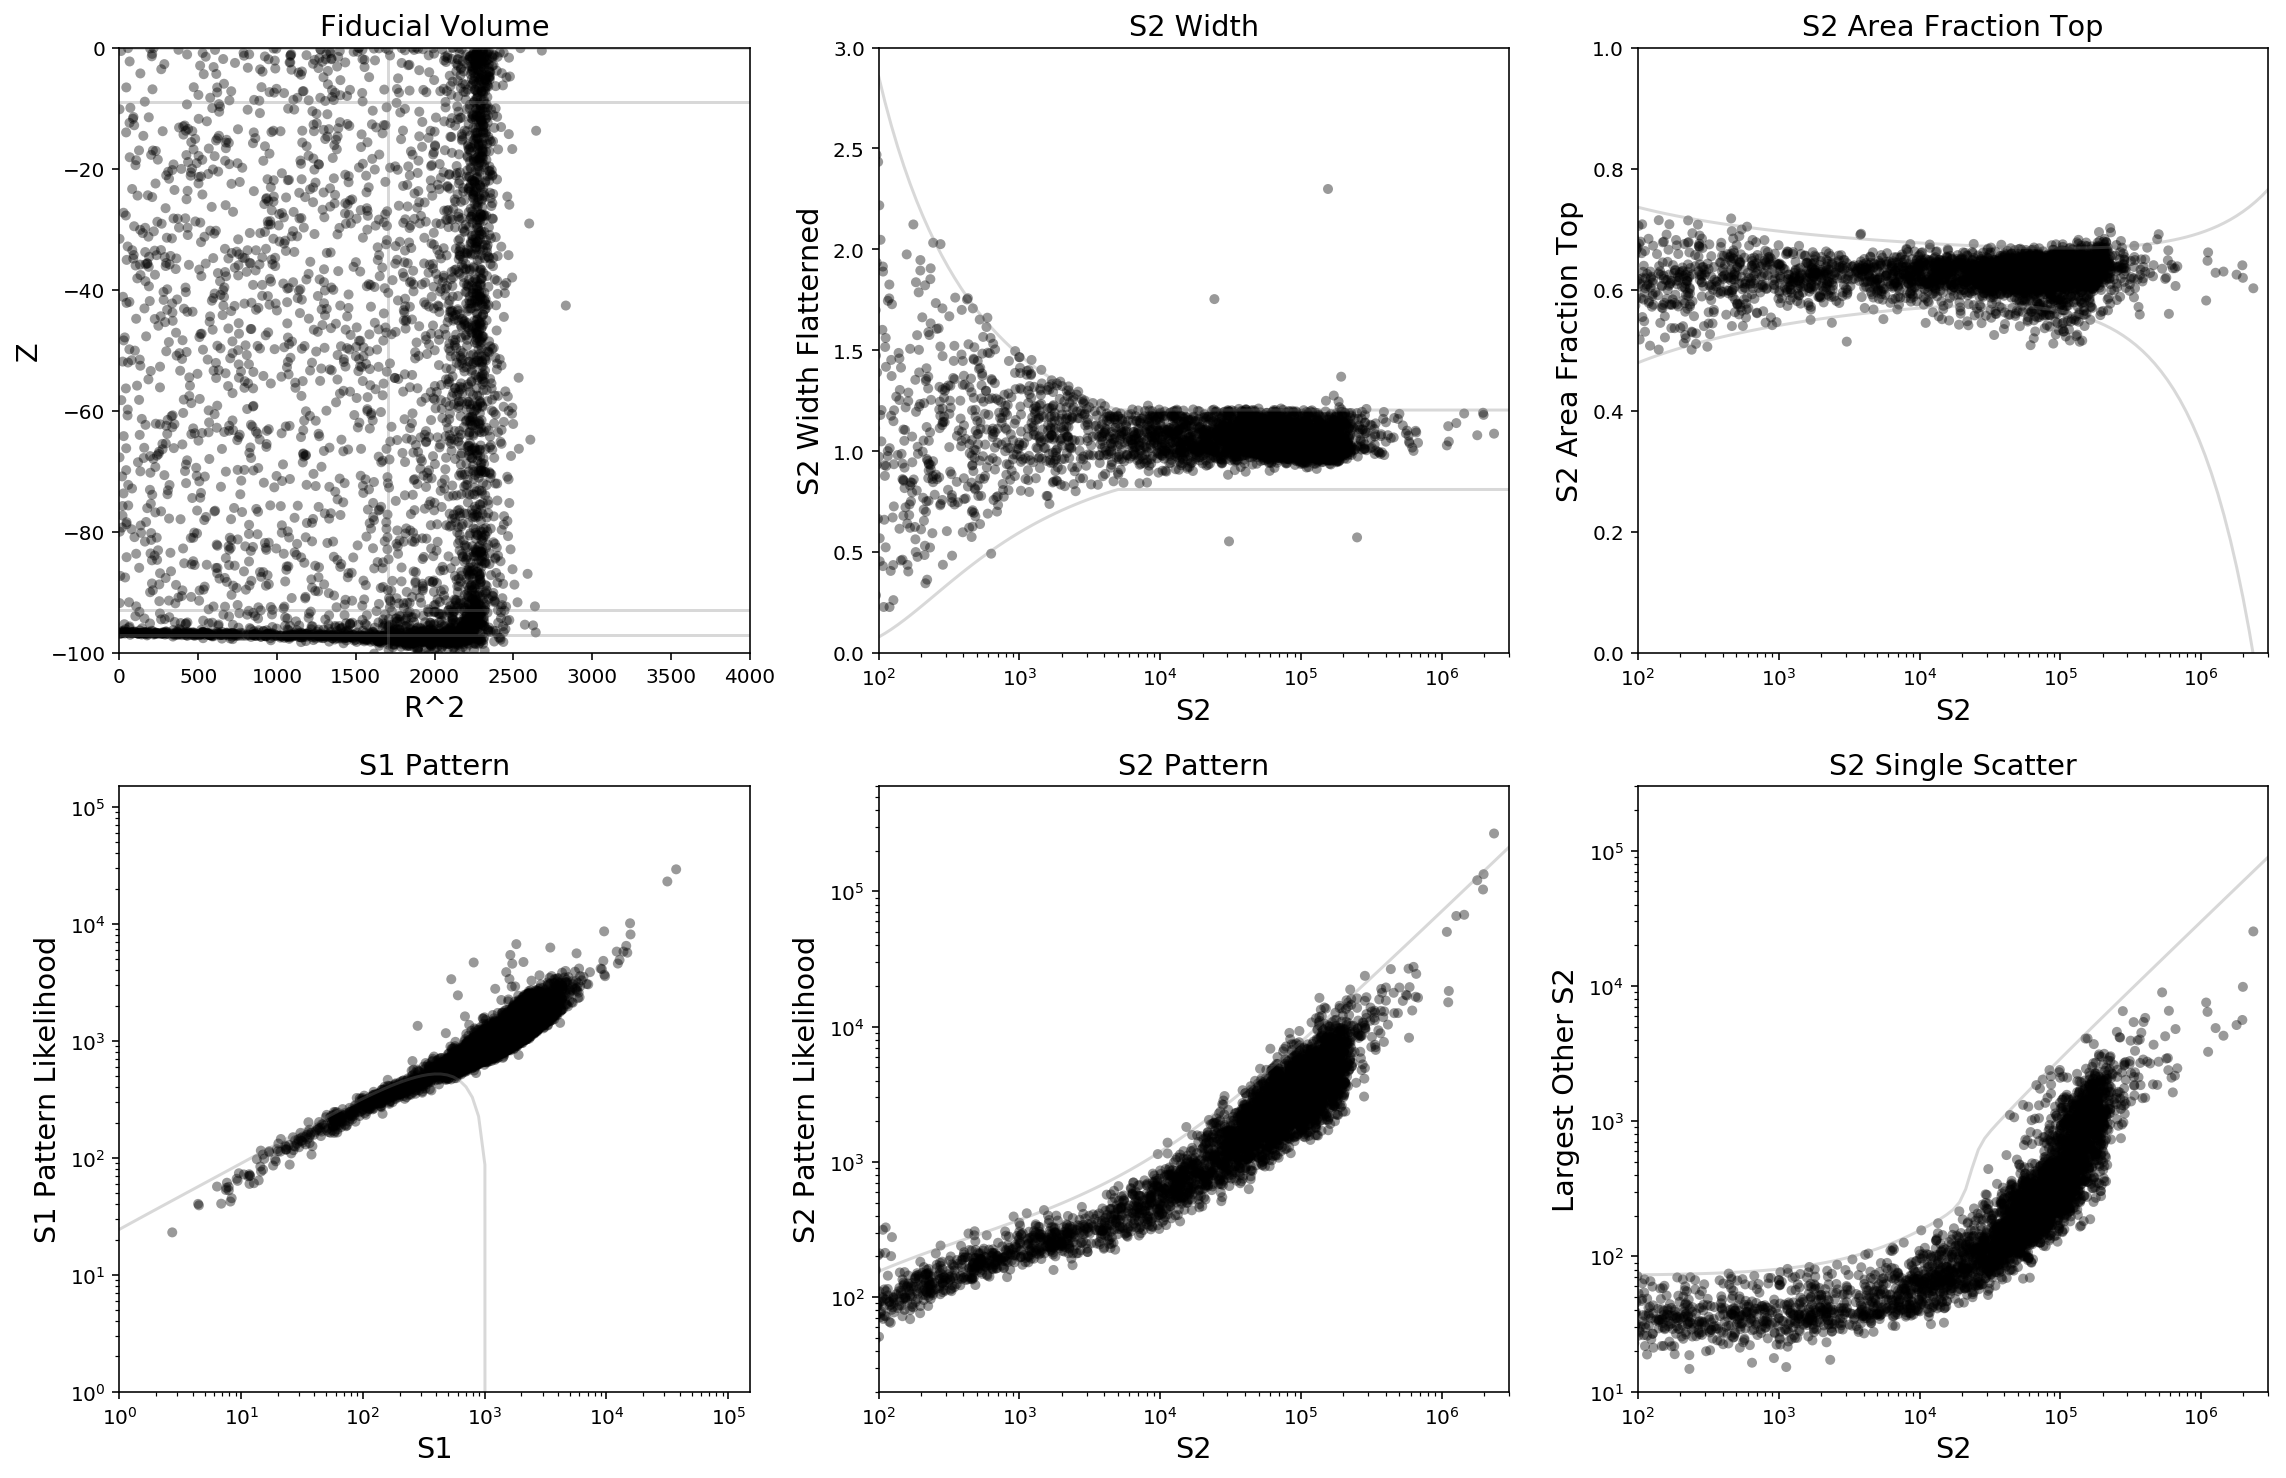

In [5]:
plt.rcParams['figure.figsize'] = (16, 15)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()
from scipy.stats import chi2

def s2_width_model_lax(z):
    return sqrt(square(229.58) - 2 * 29.35 * z / .1335 ** 3) * 1.349
    
def s2_single_scatter(s2):
    return (s2 * 0.00832 + 72.3) / (np.exp((s2 - 23300) * 5.91e-4) + 1) + (s2 * 0.03 - 109) / (np.exp((23300 - s2) * 5.91e-4) + 1)
    
normalls = dict(ls = '-', color = 'grey', alpha = 0.3)
def _ban(s1):   
    return 0
def _fdv(r2):
    for lim in [-97, -92.9, -9, 0]:
        plt.axhline(lim, **normalls)
    plt.axvline(41.26**2, **normalls)
def _s2s(s2):   
    plt.plot(s2, s2_single_scatter(s2), **normalls)
def _s2w(s2):
    k = np.clip( s2, 0, 5000) / 21.3
    plt.plot(s2, np.sqrt(chi2.ppf(1-1e-5,k) / (k-1)), **normalls)
    plt.plot(s2, np.sqrt(chi2.ppf(1e-5,k) / (k-1)), **normalls)
def _s2a(s2): 
    plt.plot(s2, 0.6177 + 3.713e-08 * s2 + 0.5460 / np.log(s2), **normalls)
    plt.plot(s2, 0.6648 - 2.590e-07 * s2 - 0.8531 / np.log(s2), **normalls)
def _s2p(s2):
    plt.plot(s2, 0.0704 * s2 + 594 * s2**0.0737 - 686, **normalls)
def _s1a(s1):
    return 0
def _s1p(s1):
    plt.plot(s1, -2.395+25.58*pow(s1, 0.5)+1.306*s1-0.06385*np.power(s1,1.5), **normalls)
    
Bs1, Bs2 = [1, 1.5e5], [100, 3e6]
#####################################################################
maps = [
dict(arg = ('{df}.r_3d_nn**2','{df}.z_3d_nn'), T = 'Fiducial Volume', sup = _fdv, Bx = [0,4e3], By = [-100,0], log = [False, False], Tx = 'R^2', Ty = 'Z'),
dict(arg = ('{df}.s2','{df}.s2_range_50p_area/s2_width_model_lax({df}.z_3d_nn)'), T = 'S2 Width', sup = _s2w, Bx = Bs2, By = [0,3], log = [True, False], Tx = 'S2', Ty = 'S2 Width Flatterned'),
dict(arg = ('{df}.s2','{df}.s2_area_fraction_top'), T = 'S2 Area Fraction Top', sup = _s2a, Bx = Bs2, By = [0,1], log = [True, False], Tx = 'S2', Ty = 'S2 Area Fraction Top'),
dict(arg = ('{df}.s1','{df}.s1_pattern_fit'), T = 'S1 Pattern', sup = _s1p, Bx = Bs1, By = [Bs1[0], Bs1[1]], log = [True, True], Tx = 'S1', Ty = 'S1 Pattern Likelihood'),
dict(arg = ('{df}.s2','{df}.s2_pattern_fit'), T = 'S2 Pattern', sup = _s2p, Bx = Bs2, By = [Bs2[0]/5, Bs2[1]/5], log = [True, True], Tx = 'S2', Ty = 'S2 Pattern Likelihood'),
dict(arg = ('{df}.s2','{df}.largest_other_s2'), T = 'S2 Single Scatter', sup = _s2s, Bx = Bs2, By = [Bs2[0]/10, Bs2[1]/10], log = [True, True], Tx = 'S2', Ty = 'Largest Other S2'),
]


fs = ['df_']
df_ = df_rn.sample(frac = 0.01)
op = [dict(color = 'k', alpha = 0.4, s = 25, edgecolor = 'none'),
      dict(color = 'b', alpha = 0.4, s = 25, edgecolor = 'none'),
     ]

for jx, f in enumerate(fs):
    for ix, m in enumerate(maps):
        ax = fig.add_subplot(331+ix)
        plt.scatter(eval(m['arg'][0].format(df = f)), eval(m['arg'][1].format(df = f)), **op[jx])
        plt_config(title = m['T'], xbounds = m['Bx'], ybounds = m['By'], xlabel = m['Tx'], ylabel = m['Ty'])
        if m['log'][0]: plt.xscale('log')
        if m['log'][1]: plt.yscale('log')

        if m['log'][0]:
            m['sup'](np.logspace(np.log10(m['Bx'][0]), np.log10(m['Bx'][1]), 101))
        else:
            m['sup'](np.linspace(m['Bx'][0], m['Bx'][1], 101))
plt.tight_layout()
plt.show()